In [32]:
!pip install geopy > delete.txt
!pip install datasets > delete.txt
!pip install torch torchvision datasets > delete.txt
!pip install huggingface_hub > delete.txt
!rm delete.txt

In [42]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `metadata_parser` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticat

In [46]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from huggingface_hub import PyTorchModelHubMixin
from PIL import Image
import os
import numpy as np
from datasets import load_dataset, Image
from huggingface_hub import hf_hub_download

# INPUTS

In [47]:
# Latitude and longitude mean and std loaded from training data
lat_mean = 39.95173675925926
lat_std = 0.0006117096745964738
lon_mean = -75.19119498148149
lon_std = 0.0007743986248108865

# Load dataset for inference
dataset_test = load_dataset("{YOUR ORGANIZATION NAME}/{DATASET NAME}", split="test")

# Data Processing

In [48]:
class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # Compute mean and std from the dataframe if not provided
        self.latitude_mean = lat_mean if lat_mean is not None else np.mean(np.array(self.hf_dataset['Latitude']))
        self.latitude_std = lat_std if lat_std is not None else np.std(np.array(self.hf_dataset['Latitude']))
        self.longitude_mean = lon_mean if lon_mean is not None else np.mean(np.array(self.hf_dataset['Longitude']))
        self.longitude_std = lon_std if lon_std is not None else np.std(np.array(self.hf_dataset['Longitude']))

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Extract data
        example = self.hf_dataset[idx]

        # Load and process the image
        image = example['image']
        latitude = example['Latitude']
        longitude = example['Longitude']
        # image = image.rotate(-90, expand=True)
        if self.transform:
            image = self.transform(image)

        # Normalize GPS coordinates
        latitude = (latitude - self.latitude_mean) / self.latitude_std
        longitude = (longitude - self.longitude_mean) / self.longitude_std
        gps_coords = torch.tensor([latitude, longitude], dtype=torch.float32)

        return image, gps_coords

In [45]:
# Transform for inference without augmentations
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Create the validation dataset and dataloader using mean and std
val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [49]:
print(dataset_test)

Dataset({
    features: ['image', 'Latitude', 'Longitude'],
    num_rows: 60
})


# Performing Inference

In [50]:
# Specify the repository and the filename of the model you want to load
repo_id = "Imagetogps/ImageToGPSproject_base_resnet18"  # Replace with your repo name
filename = "resnet_gps_regressor_complete.pth"

model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the model using torch
resnet = torch.load(model_path)
resnet.eval()  # Set the model to evaluation mode

<ipython-input-50-23faf52367f9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load(model_path)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
resnet = resnet.to(device)

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []

resnet.eval()
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = resnet(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
rmse = mean_squared_error(all_actuals, all_preds, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Using device: cuda
Mean Absolute Error: 0.00045855838106945157
Root Mean Squared Error: 0.0005641035968437791


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


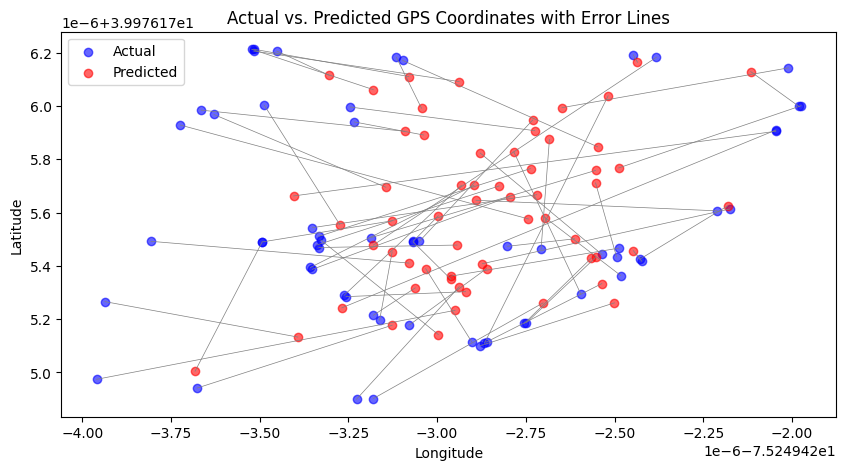

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Denormalize predictions and actual values
all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

plt.figure(figsize=(10, 5))

# Plot actual points
plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)

# Plot predicted points
plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)

# Draw lines connecting actual and predicted points
for i in range(len(all_actuals_denorm)):
    plt.plot(
        [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
        [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
        color='gray', linewidth=0.5
    )

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
plt.show()